# Presentation for sections "tools" in my thesis paper;

## GP from buttom:

In [209]:
#from __future__ import division
import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl    
mpl.rc('font',family='serif')

In [210]:
np.random.seed(42)

**The Gaussian kernel (or Radial Basis Function (RBF))**

$$ K(x,x') = \eta^2 exp\left(-\frac{|x-x'|^2}{2\ell^2}\right) $$

- The lengthscale $\ell$ determines the length of the 'wiggles' in your function. In general, you won't be able to extrapolate more than $\ell$ units away from your data.

- The output variance or amplitude $\eta^2$ determines the average distance of your function away from its mean. Every kernel has this parameter out in front; it's just a scale factor.

se http://www.cs.toronto.edu/~duvenaud/cookbook/index.html for more

In [211]:

# Define the kernel
def kernelRBF(a, b, ℓ, η):
    """ GP squared exponential kernel """
#     ℓ = 1
#     η = 1

    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return η**2 * np.exp(-(1/ℓ) * sqdist)

In [212]:
# # This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


In [213]:
def gp(ℓ,η, data):

    # GP1
    K = kernel(X, X, ℓ, η)
    L = np.linalg.cholesky(K + s*np.eye(N))

    # points (grid, not testset!) we're going to make predictions at.
    Xtest = np.linspace(0, 15, n)[:,None]

    # compute the mean at our test points.
    K_s =  kernel(X, Xtest, ℓ, η) # K*
    Lk = np.linalg.solve(L,K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, y))


    # compute the variance at our test points.
    K_ss = kernel(Xtest, Xtest, ℓ, η) # K**
    
    # draw samples from the prior at our test points.
    L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n))
    f_prior = np.dot(L, data)
    
    # compute the mean at our test points.
    L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
    
    # draw samples from the posterior at our test points.
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,15)))

    return(Xtest, f_prior, f_post)

In [214]:
def plot_gp(Xtest, f_prior, plot_n, ℓ, η):
    
    plt.subplot(1,3,plot_n)
    
    title = '$\ell$ = {}, $\eta$ = {}'.format(ℓ, η)
    
    plt.title(title, fontsize = 14)
    
    plt.plot(Xtest, f_prior, color = 'C0', alpha = 0.3)
    plt.plot(Xtest, f_prior.mean(1), color = 'C0', alpha = 1)
    plt.fill_between(Xtest.flatten(), f_prior.mean(1) + (f_prior.std(1)) * 2,  f_prior.mean(1) - (f_prior.std(1)) *2, 
                     color = 'C0', alpha = 0.1)

    
    plt.xlim(0,10)
    plt.ylim(-8,8)
    
    if plot_n == 1:
            plt.ylabel('y', fontsize = 14)
    else:
            plt.ylabel('')
            
    if plot_n == 2:
            plt.xlabel('x', fontsize = 14)
    else:
            plt.xlabel('')
    
    plt.xticks([])
    plt.yticks([])
    

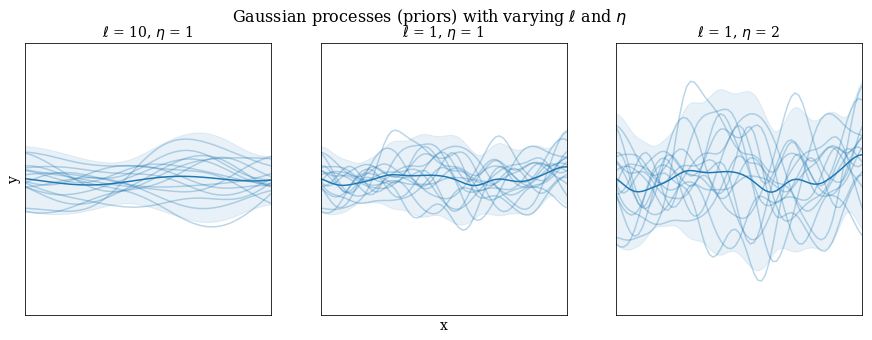

In [215]:
kernel = kernelRBF


N = 6         # number of training points.
n = 100         # number of test points.
s = 0.00005    # noise variance.
data = np.random.normal(size=(n,15))
new_data = np.random.normal(size=(n,15))

# Sample some input points and noisy versions of the function evaluated at
# these points. 

# X = np.linspace(0,10,N)[:,None]
# y = np.random.poisson(size = N)

X = np.random.uniform(0, 12, size=(N,1))
y = f(X) + s*np.random.randn(N)

Xtest0, f_prior0, f_post0 = gp(10,1, data)
Xtest1, f_prior1, f_post1 = gp(1,1, data)
Xtest2, f_prior2, f_post2 = gp(1,2, data)

fig = plt.figure(figsize = (15,5))

plot_gp(Xtest0, f_prior0, 1, 10, 1)
plot_gp(Xtest1, f_prior1, 2, 1, 1)
plot_gp(Xtest2, f_prior2, 3, 1, 2)

fig.suptitle('Gaussian processes (priors) with varying $\ell$ and $\eta$', fontsize  = 16)
plt.savefig('GP_varying_hp.pdf', bbox_inches='tight')

plt.show()

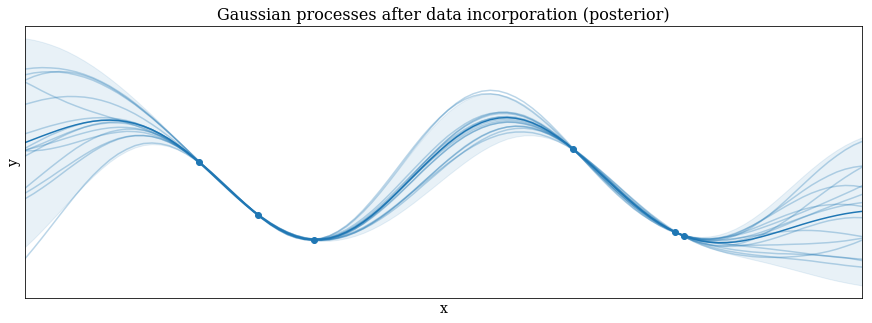

In [219]:
# draw samples from the posterior at our test points.
# L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))

fig = plt.figure(figsize = (15,5))

plt.plot(Xtest0, f_post0, color = 'C0', alpha = 0.3)
plt.plot(Xtest0.flatten(), f_post0.mean(1), color = 'C0', alpha = 1)
plt.plot(X,y, 'o', color = 'C0', alpha = 1)

plt.fill_between(Xtest0.flatten(), f_post0.mean(1) + (f_post0.std(1)) * 2,  f_post0.mean(1) - (f_post0.std(1)) *2,
                 color = 'C0', alpha = 0.1)


plt.title('Gaussian processes after data incorporation (posterior)', fontsize = 16)

plt.ylabel('y', fontsize = 14)

plt.xlabel('x', fontsize = 14)

plt.xlim(Xtest0.min(),Xtest0.max())

plt.xticks([])
plt.yticks([])
plt.savefig('GP_toy_posterior.pdf', bbox_inches='tight')


plt.show()

## GP esk with pymc3:

In [221]:
import matplotlib.cm as cm
import seaborn as sns
from pymc3.gp.util import plot_gp_dist

import scipy as sp
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm

import time

pm.__version__

'3.6'

In [222]:
# Toy-data
# prøv med det her, ellers hent noget rigtigt!

x = np.arange(1989,2019,1).reshape(-1,1)

X = np.concatenate([x,x,x])

y0 = [0,0,0,10,40,120,150,250,300,320,240,420,800,700,350,170,53,12,0,0,0,0,0,0,0,0,0,2,8,32]
y1 = [0,0,0,0,10,5,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,5,10,35,60,100,40,90,70]
y2 = [435,130,80,100,90,70,10,0,0,0,0,0,0,10,20,4,0,0,5,0,3,0,2,11,23,30,45,180,260,390]

y = np.log(np.array(y0 + y1 + y2)+1) * np.random.uniform(0.7,1,len(y1)*3) # logged fatalities

index = np.array([0]*len(y0)+[1]*len(y1)+[2]*len(y2))

# new years from x=1989 to x=2020
X_new = np.linspace(1989, 2030, 100)[:,None]

# Just for plotting
pred_years =  np.arange(2018, 2030, 1)

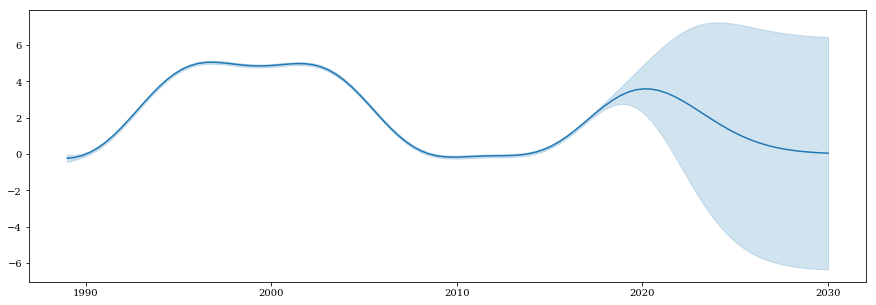

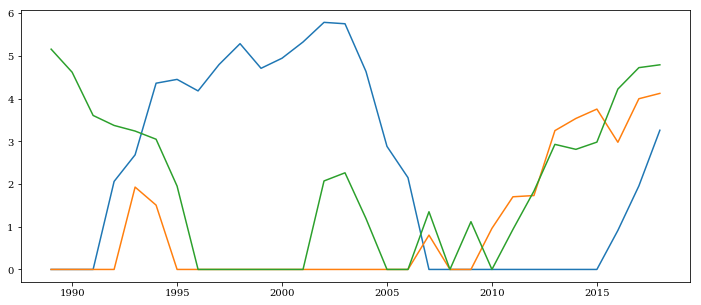

In [223]:
fig = plt.figure(figsize=(12,5))

for i in set(index):
    plt.plot(X[index == i],y[index==i])
    
plt.show()

### Shared hyper parameters:

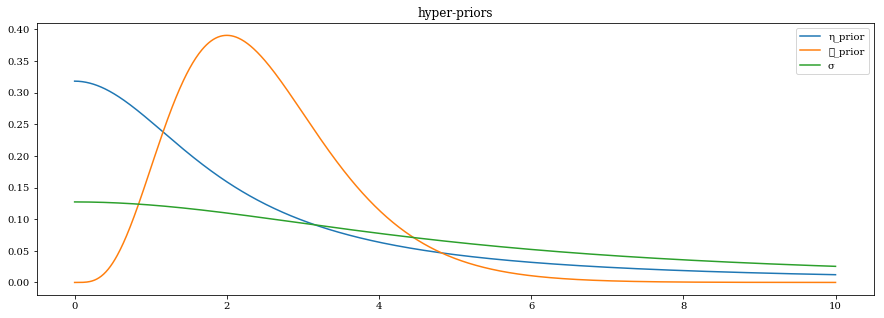

In [224]:
# Hyper parameters:

η_beta = 2
ℓ_beta = 2
ℓ_alpha = 5
σ_beta = 5

grid = np.linspace(0,10,1000)
priors = [
    ('$\eta$_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('$\ell$_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('$\sigma$', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()



In [225]:
time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == j], y=y[index == j], noise= σ)

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [226]:
time1 = time.time()

with model:
    trace = pm.sample()
    
time1 = time.time()
stepallt = (time1 - time0)/60
print('time total: {}min'.format(stepallt))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ℓ]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:54<00:00, 73.67draws/s]


time total: 1.0649469296137493min


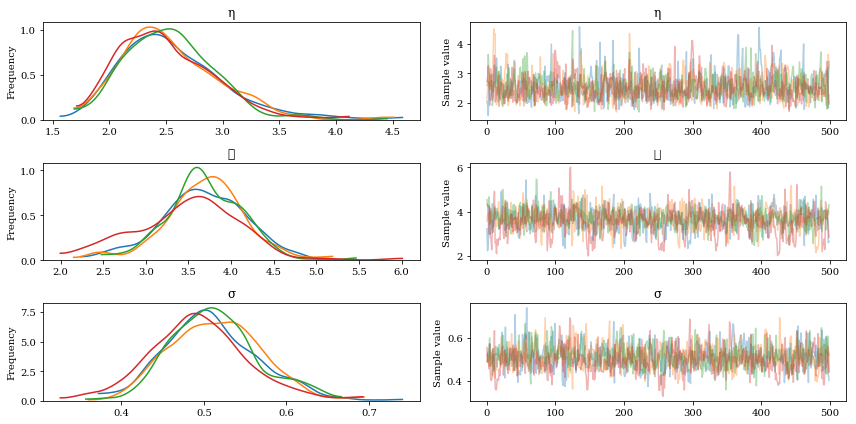

In [227]:
pm.traceplot(trace, varnames=['η', 'ℓ', 'σ'])
plt.show()

In [228]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.639123,0.521709,0.019827,2.463955,4.555405,573.197182,1.015289
η__0,2.543735,0.431415,0.012195,1.775428,3.329679,1066.083304,1.000985
σ__0,0.507336,0.056483,0.001878,0.399176,0.620040,729.601161,1.014493


In [229]:
mp = {'ℓ' : np.array([pm.summary(trace)['mean'].iloc[0]]),  
      'η': np.array([pm.summary(trace)['mean'].iloc[1]]), 
      'σ' : np.array([pm.summary(trace)['mean'].iloc[2]])}

mp

{'η': array([2.54373472]), 'σ': array([0.5073357]), 'ℓ': array([3.63912331])}

In [230]:
time2 = time.time()
step0t = (time1 - time0)/60
step1t = (time2 - time1)/60

stepallt = (time2 - time0)/60

print('step 0: {}min \n step 1: {} \n time total: {}min'.format(step0t, step1t, stepallt))

step 0: 1.0649469296137493min 
 step 1: 0.04611127773920695 
 time total: 1.1110582073529562min


In [231]:
time_0 = time.time()

mu_list = []
var_list = []

for i, j in enumerate(np.unique(index)):
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ }, diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    
    print('{}/{}'.format(i+1,np.unique(index).shape[0]), end = '-')
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


1/3-2/3-3/3-total 0.6238407293955485 min


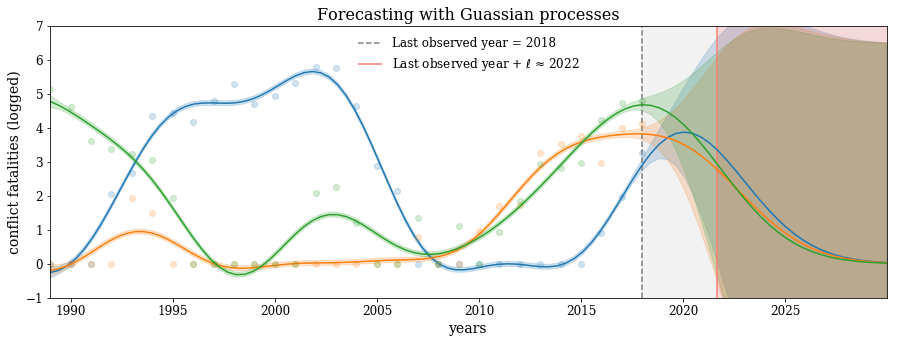

In [232]:
fig = plt.figure(figsize=(15,5))


for i, j in enumerate(np.unique(index)):
    
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.fill_between(X_new.flatten(), mu_list[i] + (var_list[i]), mu_list[i] - (var_list[i]) , color = color, alpha = 0.2)
    plt.plot(X[index == j], y[index == j], 'o' , ms=6, alpha=0.2, color = color)
    
plt.vlines(X.max(),-1,y.max()*2, linestyles='--', color = 'gray', label='Last observed year = ' + str(X.max()))
plt.vlines(X.max() +  mp['ℓ'],-1,y.max()*2, linestyles='-', color = 'salmon', 
           label='Last observed year + $\ell$ ≈ ' + str(int(X.max()+ mp['ℓ'][0].round(0))))

    
fill_min = pred_years.min()
fill_max = pred_years.max() + 2
fill_range = np.arange(fill_min, fill_max, 1)

plt.fill_between(fill_range,y.min()-1,y.max()*2, color = 'gray', alpha = 0.1)#, label = '"consultable" forcastings')
    
fill_min = pred_years.min() + mp['ℓ']
fill_max = pred_years.max() + 2
fill_range = np.arange(fill_min, fill_max, 1)

plt.fill_between(fill_range,y.min()-1,y.max()*2, color = 'red', alpha = 0.1)#, label = '"unconsultable" forcastings')
    

plt.ylim(-1,7)
plt.xlim(X_new.min(),X_new.max())

plt.xticks(np.arange(1990,2030,5), fontsize = 12)
plt.yticks(fontsize = 12)


plt.legend(frameon = False, loc = 9, fontsize = 12)

plt.title('Forecasting with Guassian processes', fontsize = 16)
plt.xlabel('years', fontsize = 14)
plt.ylabel('conflict fatalities (logged)', fontsize = 14)

plt.savefig('GP_toy_eks.pdf', bbox_inches='tight')

plt.show()